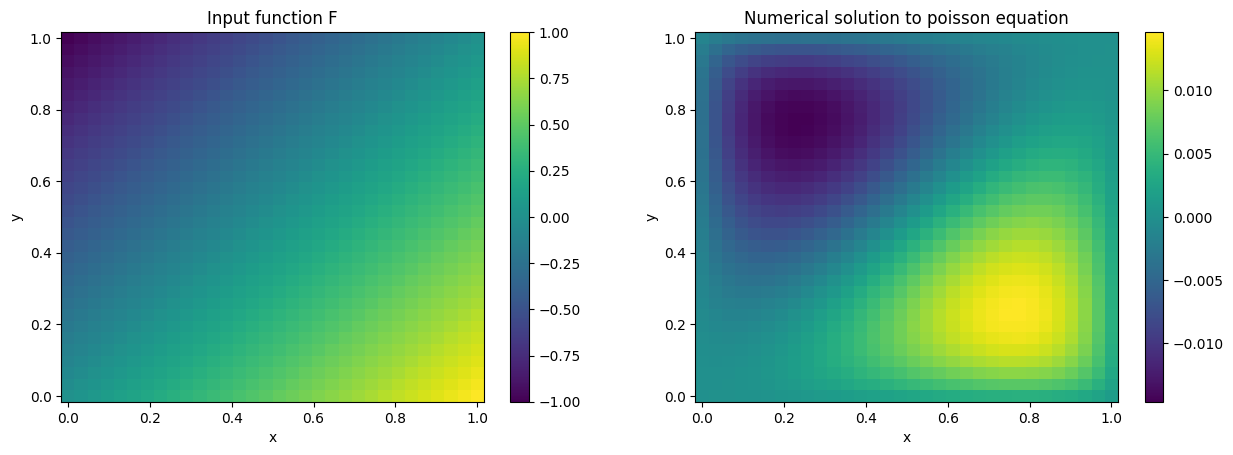

torch.Size([1, 1, 32, 32])


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg
import torch
torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

N = 32
h = 1.0 / (N - 1)
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y)


#SEE FORM OF OPERATOR IN DATGEN PAPER, SOLVING Lu=-f

neumann = False

# Define f
F = np.abs(X -0.5) * np.abs(Y-0.5)
#F = np.sin(X)*np.sin(Y)/np.sqrt(2*np.pi**2) - np.sin(2*X) * np.sin(Y) / np.sqrt(5*np.pi**2)
F = X - Y
#F = X**2 + Y**2
#F = X*Y



#redefine for numerical solver, which solves Lu = f, so have to redefine
F_num = -F

#numerical solver 

# Initialize the sparse matrix A
main_diagonal = np.ones(N**2) * -4 / h**2
offset_diagonals = np.ones(N**2 - 1) / h**2
offset_diagonals[N-1::N] = 0  # Fix the boundary effects where wrap-around occurs
far_diagonals = np.ones(N**2 - N) / h**2

# Create the sparse matrix A using diags
A = sp.diags(
    [main_diagonal, offset_diagonals, offset_diagonals, far_diagonals, far_diagonals],
    [0, -1, 1, -N, N], shape=(N**2, N**2), format='csr')

# Apply boundary conditions (zero boundary conditions applied by default)

if neumann:
    print(3)
    for i in range(N):
        if i == 0 or i == N-1:
            A[i,:] = A[-(i+1),:] = 0
            A[i,i] = A[-(i+1),-(i+1)] = 1/h
        if i % N == 0 or (i+1) % N == 0:
            A[i,:] = 0
            A[i,i] = 1/h

F_num = F_num.ravel()

if neumann:
    F_num[0:N] =F_num[-N:] = F_num[::N] = F_num[N-1::N] = 0

# Solve the linear system
u = scipy.sparse.linalg.spsolve(A, F_num)
U = u.reshape((N, N))


# Plotting
fig, axs = plt.subplots(nrows = 1, ncols = 2)
fig.set_figwidth(15)

fig1 = axs[0].pcolormesh(X,Y,F)
fig.colorbar(fig1)
axs[0].set_title("Input function F")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")



fig2 = axs[1].pcolormesh(X,Y,U)
fig.colorbar(fig2)
axs[1].set_title("Numerical solution to poisson equation")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
plt.show()



#save input function

F = torch.tensor(F)[None,None,:]
print(F.shape)
torch.save(F,"../finput.pt")

In [2]:

import matplotlib.pyplot as plt
import sys, os

#from neuralop.training import Trainer 

from neuralop.utils import count_model_params
from neuralop.models import FNO2d
from neuralop import LpLoss

import torch.nn.functional as F

from models.FNO_bayesian import FNO2D_Bayesian
from data_transforms.positional_embedding import PositionalEmbedding2D
from losses.nll import NLL


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.cuda.empty_cache()

print(device)

ModuleNotFoundError: No module named 'models'

In [ ]:
M = 1
model_list = [FNO2D_Bayesian(n_modes= 12, hidden_channels=32,in_ch=3,non_linearity=F.gelu) for i in range(M)]
#n_params = count_model_params(model)
#print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


#load the model if needed
a = 0
if a == 1:
    state_dict = torch.load("checkpoints/checkpoints_working_100000_300_relu_0.5_25_best/model_state_dict.pt")
    for i in range(M): model_list[i].load_state_dict(state_dict)


In [ ]:
#optimizer
optimizer_list = [torch.optim.Adam(model_list[i].parameters(), lr=0.001,weight_decay=1e-4) for i in range(M)]

scheduler_list = [torch.optim.lr_scheduler.StepLR(optimizer_list[i],step_size=100,gamma = 0.5) for i in range(M)]
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=301*100)

# Creating the losses

train_loss = NLL

sys.stdout.flush()

In [ ]:
x_train = torch.load('../../data_poisson/dirichlet_100000_32_x.pt').clone().type(torch.FloatTensor)
y_train = torch.load('../../data_poisson/dirichlet_100000_32_y.pt').clone().type(torch.FloatTensor)
grid_boundaries = [[0,1],[0,1]]

x_train = PositionalEmbedding2D([[0,1],[0,1]])(x_train)
y_train = y_train.unsqueeze(1)
train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_train, y_train),
        batch_size=100,
        shuffle=True
    )

train_loader_list = [train_loader for i in range(M)]


d:\University-local\Imperial\Term_3\Project\.venv\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
#test set
x_test = torch.load('../../data_poisson/dirichlet_test_100_32_x.pt').clone().type(torch.FloatTensor)
y_test = torch.load('../../data_poisson/dirichlet_test_100_32_y.pt').clone().type(torch.FloatTensor)


x_test = PositionalEmbedding2D([[0,1],[0,1]])(x_test)
y_test = y_test.unsqueeze(1)

test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_test, y_test),
        batch_size=10,
        shuffle=True
    )


test_loader_list = [test_loader for i in range(M)]

eval_loss = train_loss

In [ ]:
from callbacks.checkpointcallback_ensemble import CheckpointCallbackEnsemble
from callbacks.loggercallback_ensemble import LoggerCallbackEnsemble
from callbacks.loggercallback import LoggerCallback

save_dir = "./checkpoints_multi"

ckpt = CheckpointCallbackEnsemble(save_dir=save_dir,
                                       save_freq=10)
logger = LoggerCallbackEnsemble(save_dir=save_dir, n_models = M)

from training.trainer_ensemble import Trainer_Ensemble
trainer = Trainer_Ensemble(model_list=model_list, n_epochs=501,
                  device=device,
                  callbacks=[ckpt,logger],
                  log_test_interval=1,
                  verbose=True)

In [ ]:

trainer.train(train_loader_list=train_loader_list,
              test_loaders_list=test_loader_list,
              optimizer_list=optimizer_list,
              scheduler_list=scheduler_list, 
              regularizer=None, 
              training_loss=train_loss,
              eval_losses=eval_loss
              )

Model 0 - Train Epoch: 0 	Loss: -2.664275
Test set: Average loss: -3.9860

Model saved at epoch 0.
Model 1 - Train Epoch: 0 	Loss: -2.778307
Test set: Average loss: -3.7679

Model saved at epoch 0.
Model 2 - Train Epoch: 0 	Loss: -2.840480
Test set: Average loss: -3.9589

Model saved at epoch 0.
Model 3 - Train Epoch: 0 	Loss: -2.740229
Test set: Average loss: -1.6633

Model saved at epoch 0.
Model 4 - Train Epoch: 0 	Loss: -2.730219
Test set: Average loss: -2.1304

Model saved at epoch 0.
Model 0 - Train Epoch: 1 	Loss: -3.567271
Test set: Average loss: -4.3202

Model 1 - Train Epoch: 1 	Loss: nan
Test set: Average loss: nan

Model 2 - Train Epoch: 1 	Loss: -3.555754
Test set: Average loss: -3.9359

Model 3 - Train Epoch: 1 	Loss: -3.389875
Test set: Average loss: -3.3632

Model 4 - Train Epoch: 1 	Loss: -3.525582
Test set: Average loss: -4.2557

Model 0 - Train Epoch: 2 	Loss: -4.094909
Test set: Average loss: -4.3756

Model 1 - Train Epoch: 2 	Loss: nan
Test set: Average loss: nan



KeyboardInterrupt: 

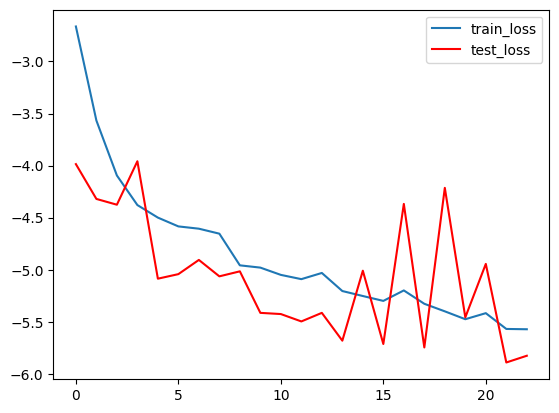

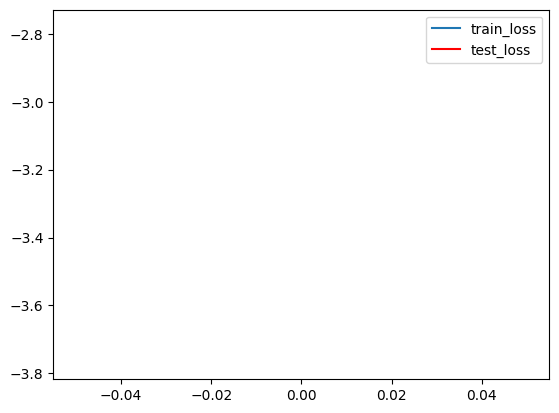

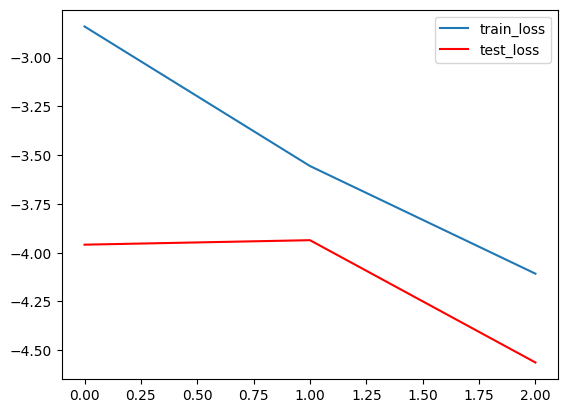

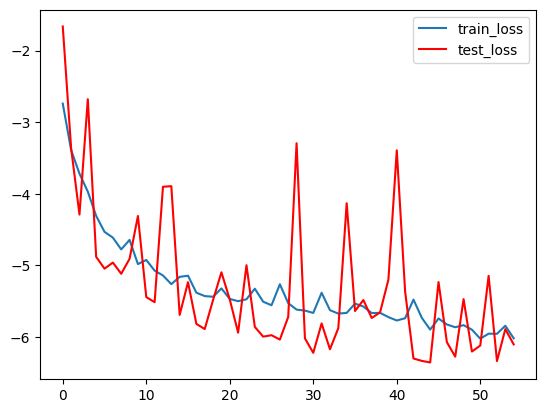

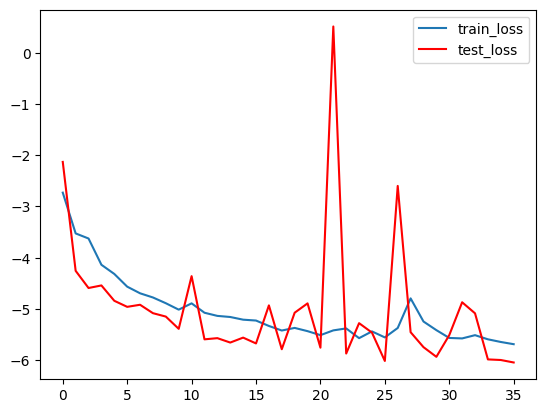

In [ ]:
import pandas as pd
losses = [pd.read_csv(f"./checkpoints_multi/loss_{i+1}.csv") for i in range(M)]





for i in range(M):
    plt.plot(np.arange(0,len(losses[i]),1),losses[i]["Train Loss"],"-",label="train_loss")
    plt.plot(np.arange(0,len(losses[i]),1),losses[i]["Test Loss"],"-r",label="test_loss")
    plt.legend()
    plt.show()

In [ ]:
#prediction time for f


for i in range(M): model_list[i].eval() 



sample = torch.load("../finput.pt").clone().type(torch.FloatTensor)


#preprocessing
sample = PositionalEmbedding2D(grid_boundaries=grid_boundaries)(sample).to(device)

out = [model_list[i](sample) for i in range(M)]

mu_out = torch.mean(torch.stack([out[i][0] for i in range(M)]),dim=0)
var_out = (torch.mean(torch.stack([torch.exp(out[i][1]) + torch.square(out[i][0]) for i in range(M)]),dim=0) - torch.square(mu_out))
var_unseen = var_out


U = torch.tensor(U).to(device)

actual_sample = torch.normal(mu_out,torch.sqrt(var_out))
print(train_loss(mu_out,torch.log(var_out),U,))
print(LpLoss(d=2, p =2)(actual_sample,U))


# Plotting
fig, axs = plt.subplots(nrows = 1, ncols = 2,gridspec_kw={'width_ratios': [1, 1]})
fig.set_figwidth(15)


#prediction
fig1 = axs[0].pcolormesh(X,Y,actual_sample[0,0,:,:].cpu().detach().numpy())
fig.colorbar(fig1)
axs[0].set_title("Model Prediction")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")



#actual
fig2 = axs[1].pcolormesh(X,Y,U.cpu())
fig.colorbar(fig2)
axs[1].set_title("Numerical Solution")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
plt.show()


RuntimeError: normal expects all elements of std >= 0.0

tensor(-6755.3188, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0.0246, device='cuda:0', grad_fn=<SqueezeBackward0>)


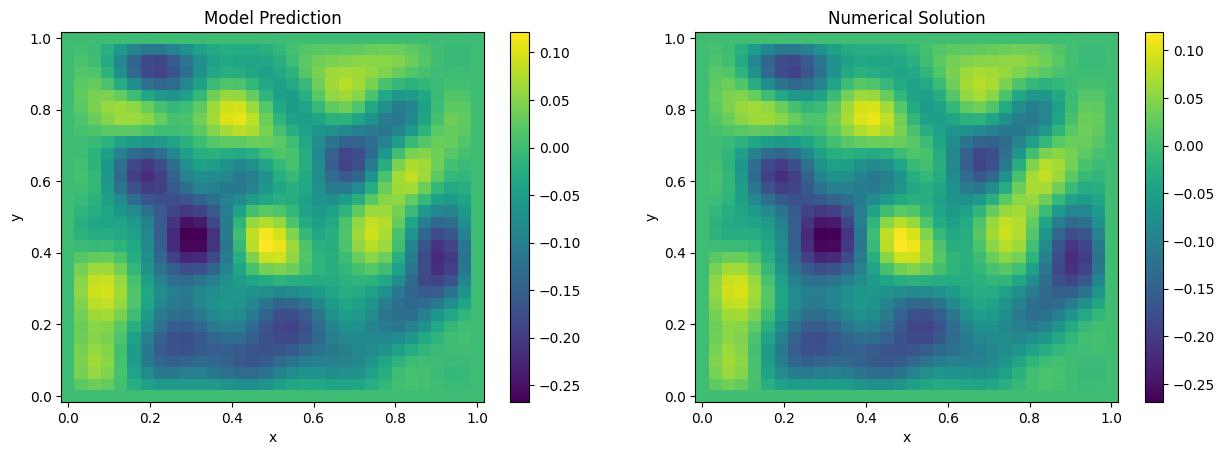

In [ ]:
#prediction time
i = np.random.randint(0,100)
sample = test_loader.dataset[i][0].unsqueeze(0).to(device)

#preprocessing
out = [model_list[i](sample) for i in range(M)]

mu_out = torch.mean(torch.stack([out[i][0] for i in range(M)]),dim=0)
var_out = (torch.mean(torch.stack([torch.exp(out[i][1]) + torch.square(out[i][0]) for i in range(M)]),dim=0) - torch.square(mu_out))
var_seen = var_out


print(train_loss(mu_out,torch.log(var_out),test_loader.dataset[i][1].to(device)))

#print(NLL_2(*out,train_loader.dataset[i][1].to(device)))




actual_sample = torch.normal(mu_out,torch.sqrt(var_out))
print(LpLoss(d=2, p =2)(actual_sample,test_loader.dataset[i][1].to(device)))


# Plotting
fig, axs = plt.subplots(nrows = 1, ncols = 2,gridspec_kw={'width_ratios': [1, 1]})
fig.set_figwidth(15)


#prediction
fig1 = axs[0].pcolormesh(X,Y,actual_sample[0,0,:,:].cpu().detach().numpy())
fig.colorbar(fig1)
axs[0].set_title("Model Prediction")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")


#actual
fig2 = axs[1].pcolormesh(X,Y,test_loader.dataset[i][1].unsqueeze(0)[0,0,:,:].cpu().detach().numpy())
fig.colorbar(fig2)
axs[1].set_title("Numerical Solution")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
plt.show()


In [ ]:
var_seen

tensor([[[[5.5197e-09, 3.0287e-09, 4.8462e-09,  ..., 1.5824e-09,
           2.1653e-09, 4.6906e-09],
          [2.6152e-09, 2.5227e-07, 6.9558e-07,  ..., 4.4778e-07,
           2.7809e-07, 1.1175e-08],
          [4.1481e-09, 3.8114e-07, 1.4582e-06,  ..., 1.4466e-06,
           3.0201e-07, 6.0675e-09],
          ...,
          [2.0220e-09, 3.3437e-07, 6.1283e-07,  ..., 4.3170e-07,
           1.7999e-07, 2.6761e-09],
          [2.4942e-09, 2.7992e-07, 3.6906e-07,  ..., 1.2193e-07,
           4.9892e-07, 1.5719e-09],
          [5.5310e-09, 3.4437e-09, 1.5851e-09,  ..., 2.1799e-09,
           2.5105e-09, 7.1019e-09]]]], device='cuda:0', grad_fn=<SubBackward0>)

In [ ]:
var_unseen

tensor([[[[3.8132e-10, 1.1762e-10, 1.6868e-10,  ..., 9.9524e-10,
           8.0471e-10, 1.3826e-10],
          [1.6380e-10, 2.5852e-09, 1.5664e-09,  ..., 9.9824e-09,
           3.7410e-09, 3.6322e-09],
          [2.8060e-10, 1.0519e-08, 4.1816e-09,  ..., 1.2621e-08,
           1.2688e-08, 2.4604e-09],
          ...,
          [1.4354e-09, 7.0850e-09, 7.6616e-09,  ..., 1.5627e-08,
           1.1038e-08, 4.7870e-10],
          [2.1389e-09, 2.4799e-09, 4.8060e-09,  ..., 8.9929e-09,
           1.1840e-08, 5.8979e-10],
          [3.5602e-10, 2.7592e-10, 4.6017e-10,  ..., 3.1755e-10,
           1.8706e-10, 3.5573e-10]]]], device='cuda:0', grad_fn=<SubBackward0>)

In [ ]:
(var_unseen<var_seen ).sum()/torch.numel(var_unseen)*100


tensor(99.5117, device='cuda:0')